In [63]:
import os
import json
from collections import OrderedDict
import pandas as pd
from glob import glob
import xml.etree.ElementTree as ET
import math
import numpy as np
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk import word_tokenize
from rouge_score import rouge_scorer

import matplotlib.pyplot as plt

In [2]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')

In [14]:
def clean_sentence(text):
    text = text.replace("&quot;",'"')
    text = text.replace("-",' ')
    return text

In [15]:
def remove_stop_words(sentence):
    tokens = word_tokenize(sentence)
    cleaned_tokens = []
    for token in tokens:
        if token not in stops:
            cleaned_tokens.append(token)
    return " ".join(cleaned_tokens)

In [16]:
stops = set(stopwords.words('english'))

In [17]:
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2'], use_stemmer=True)

In [18]:
base_dir = "/home/xxl190027/scisumm-corpus/data/Test-Set-2018/"
files = glob(base_dir+"*")

In [19]:
all_citing_paper_sentences = {}
all_citing_paper_sentences_lookup = {}
for file in files:
    citing_files = glob(file+"/Citance_XML/*.xml")
    for xml_path in citing_files:
        paper_name = os.path.split(xml_path)[-1].split(".")[0]
        tree = ET.parse(xml_path)
        root = tree.getroot()
        sentences = {}
        sentences_lookup = {}
        for node in root.findall("S"):
            sentence = node.text.strip().replace("  "," ")
            sentence = clean_sentence(sentence)
            sid = int(node.attrib["sid"])
            sentences[sid] = sentence
            sentences_lookup[sentence] = sid
        for abstract_node in root.findall("ABSTRACT"):
            for node in abstract_node.findall("S"):
                sentence = node.text.strip().replace("  "," ")
                sentence = clean_sentence(sentence)
                sid = int(node.attrib["sid"])
                sentences[sid] = sentence
                sentences_lookup[sentence] = sid
        for section_node in root.findall("SECTION"):
            for node in section_node.findall("S"):
                sentence = node.text.strip().replace("  "," ")
                sentence = clean_sentence(sentence)
                sid = int(node.attrib["sid"])
                sentences[sid] = sentence
                sentences_lookup[sentence] = sid
        all_citing_paper_sentences[paper_name] = sentences
        all_citing_paper_sentences_lookup[paper_name] = sentences_lookup

In [37]:
citing_titles = {citing_paper_name: sentences[0] for citing_paper_name, sentences in all_citing_paper_sentences.items()}

In [38]:
citing_titles_lookup = {v:k for k,v in citing_titles.items()}

In [39]:
citing_titles_list = list(citing_titles_lookup.keys())

In [24]:
acl_title_map = OrderedDict()
with open("/data/XiangciLi/20200705v1/acl/metadata.jsonl") as f:
    for line in tqdm(f):
        meta = json.loads(line)
        acl_title_map[meta["paper_id"]] = meta["title"]

40317it [00:00, 40379.53it/s]


In [45]:
acl_title_map_lookup = {v:k for k,v in acl_title_map.items()}

In [28]:
distant_ids = []
with open("sorted_sentence_ROUGE_distant_all.jsonl") as f:
    for line in f:
        obj = json.loads(line)
        distant_ids.append(obj["id"])

In [29]:
train_ids = []
with open("sorted_sentence_ROUGE_train_all.jsonl") as f:
    for line in f:
        obj = json.loads(line)
        train_ids.append(obj["id"])

In [30]:
seen_s2orc_ids = set([k.split("_")[0] for k in (distant_ids + train_ids)])

In [32]:
seen_s2orc_titles = [acl_title_map[ID] for ID in seen_s2orc_ids]

In [33]:
seen_s2orc_titles

['Injecting Logical Background Knowledge into Embeddings for Relation Extraction',
 'Creating a Corpus for Russian Data-to-Text Generation Using Neural Machine Translation and Post-Editing',
 'Transformer-based Neural Machine Translation System for Tamil – English',
 'Combining Knowledge Hunting and Neural Language Models to Solve the Winograd Schema Challenge',
 'The Arabic Online Commentary Dataset: an Annotated Dataset of Informal Arabic with High Dialectal Content',
 'MalwareTextDB: A Database for Annotated Malware Articles',
 'Multi-Task Learning for Coherence Modeling',
 'context2vec: Learning Generic Context Embedding with Bidirectional LSTM',
 'The Role of Context in Neural Morphological Disambiguation',
 'The price of debiasing automatic metrics in natural language evaluation',
 'Stance Classification in Rumours as a Sequential Task Exploiting the Tree Structure of Social Media Conversations',
 'Obligation and Prohibition Extraction Using Hierarchical RNNs',
 'Aligning Feature

In [34]:
seen_s2orc_titles_embedding = model.encode(seen_s2orc_titles)

In [35]:
seen_s2orc_titles_embedding.shape

(10581, 384)

In [40]:
citing_titles_embedding = model.encode(citing_titles_list)

In [41]:
similarity_scores = citing_titles_embedding.dot(seen_s2orc_titles_embedding.T)

In [42]:
similarity_scores.shape

(220, 10581)

In [43]:
match_indices = np.argsort(similarity_scores,axis=1)[:,-1]

In [48]:
SciSumm2CORWA_seen = {}
for i, (citing_title, idx) in enumerate(zip(citing_titles_list, match_indices)):
    if similarity_scores[i][idx] >= 0.9:
        SciSumm2CORWA_seen[citing_titles_lookup[citing_title]] = acl_title_map_lookup[seen_s2orc_titles[idx]]


In [50]:
len(SciSumm2CORWA_seen)

75

In [51]:
SciSumm2CORWA_seen

{'H05-1094': '161340',
 'N06-1037': '15660411',
 'P04-1054': '7395989',
 'P05-1053': '3160937',
 'P07-1055': '1347118',
 'W05-0602': '2046600',
 'W05-0636': '1544330',
 'W06-0508': '14551434',
 'W04-1506': '847893',
 'N12-1007': '6557769',
 'P11-2084': '16730027',
 'D12-1129': '16502540',
 'P12-1048': '3707608',
 'P14-1012': '5709441',
 'P14-2093': '17154151',
 'P04-1013': '1588411',
 'P11-1086': '311696',
 'I08-2105': '2216585',
 'P06-1012': '2223228',
 'P10-1155': '5951182',
 'E06-1010': '7966094',
 'N07-1050': '49573952',
 'P08-1006': '5060957',
 'P11-2121': '13313668',
 'W05-1505': '7966094',
 'D08-1094': '1588782',
 'D11-1094': '3523156',
 'P10-1097': '5540599',
 'W11-1310': '18347073',
 'D12-1046': '17830435',
 'D12-1133': '1500270',
 'P11-1141': '15126078',
 'W10-1404': '847893',
 'C10-1132': '885793',
 'C10-1135': '8027785',
 'D12-1126': '12524250',
 'P12-1110': '10011032',
 'D11-1039': '1140108',
 'D11-1140': '8597719',
 'D12-1069': '5633240',
 'N12-1049': '627938',
 'P12-1045

In [67]:
#with open("SciSumm2CORWA_seen.json","w") as f:
#    json.dump(SciSumm2CORWA_seen, f)

In [59]:
full_texts = {}
for file in files:
    paper_name = os.path.split(file)[-1]
    xml_path = file + "/Reference_XML/"+paper_name+".xml"
    tree = ET.parse(xml_path)
    root = tree.getroot()
    sentences = {}
    for node in root.findall("S"):
        sentence = node.text.strip().replace("  "," ")
        sentence = clean_sentence(sentence)
        sid = int(node.attrib["sid"])
        sentences[sid] = {
            "text": sentence,
            "no_stop": remove_stop_words(sentence).lower(),
        }
    for abstract_node in root.findall("ABSTRACT"):
        for node in abstract_node.findall("S"):
            sentence = node.text.strip().replace("  "," ")
            sentence = clean_sentence(sentence)
            sid = int(node.attrib["sid"])
            sentences[sid] = {
                "text": sentence,
                "no_stop": remove_stop_words(sentence).lower(),
            }
    for section_node in root.findall("SECTION"):
        for node in section_node.findall("S"):
            sentence = node.text.strip().replace("  "," ")
            sentence = clean_sentence(sentence)
            sid = int(node.attrib["sid"])
            sentences[sid] = {
                "text": sentence,
                "no_stop": remove_stop_words(sentence).lower(),
            }
    full_texts[paper_name] = sentences

In [61]:
lens = [len(sentences) for name, sentences in full_texts.items()]

In [66]:
lens

[191,
 113,
 176,
 200,
 154,
 147,
 415,
 194,
 114,
 203,
 198,
 142,
 175,
 165,
 233,
 111,
 179,
 288,
 257,
 149]

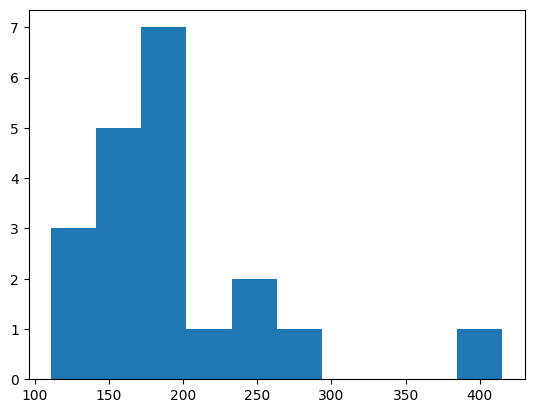

In [64]:
plt.figure()
plt.hist(lens)
plt.show()

In [ ]:
base_dir_gold = "/home/xxl190027/scisumm-corpus/data/Test-Set-2018-Gold/Task1/"
gold_files = glob(base_dir_gold+"*")

In [ ]:
all_annotations = {}
for gold_file in gold_files:
    gold_file_name = os.path.split(gold_file)[-1]
    paper_name, annotator = gold_file_name.split(".")[0].split("_")
    df = pd.read_csv(gold_file)
    this_paper = all_annotations.get(paper_name, {})
    for i in range(len(df)):
        citing_paper_name = df["Citing Article"][i]
        citing_text = df["Citation Text Clean"][i]
        citation_marker = str(df["Citation Marker"][i])
        this_citance = this_paper.get(df["Citance Number"][i], {
            "Citing Article": citing_paper_name,
            "Citation Text": citing_text,
            "Citation Marker": citation_marker,
            "CTS": {},
        })
        if len(this_citance["Citation Marker"]) < len(citation_marker):
            this_citance["Citation Marker"] = citation_marker
        #print(this_citance["Citation Text"] , df["Citation Text Clean"][i])
        if this_citance["Citing Article"] != df["Citing Article"][i]:
            continue
            #print(paper_name, annotator, df["Citance Number"][i], this_citance["Citing Article"] , df["Citing Article"][i])
        #assert(this_citance["Citing Article"] == df["Citing Article"][i])
        #assert(this_citance["Citation Text"] == df["Citation Text Clean"][i])
        raw_offsets = df["Reference Offset"][i]
        offsets = []
        if type(raw_offsets)==str and raw_offsets not in {"0","???"}:
            raw_offsets = raw_offsets.replace(";",",")
            for num_str in raw_offsets.split(","):
                cleaned = num_str.strip().replace("'","")
                if cleaned:
                    offsets.append(int(cleaned))
        elif type(raw_offsets) == np.float64 and not np.isnan(raw_offsets):
            offsets.append(int(raw_offsets))
        elif type(raw_offsets) == np.int64:
            offsets.append(int(raw_offsets))
        this_citance["CTS"][annotator] = offsets
        this_paper[df["Citance Number"][i]] = this_citance
    all_annotations[paper_name] = this_paper

In [ ]:
all_citation_texts = {}
for cited_paper_name, citations in all_annotations.items():
    for citation_idx, citation in citations.items():
        citing_paper_name = citation["Citing Article"]
        citation_text = citation["Citation Text"]
        this_paper = all_citation_texts.get(citing_paper_name,[])
        this_paper.append(citation_text)
        all_citation_texts[citing_paper_name] = this_paper

In [ ]:
all_citation_texts_idx_lookup = {}
for citing_paper_name, citation_texts in all_citation_texts.items():
    if citing_paper_name in all_citing_paper_sentences:
        citation_text_embedding = model.encode(citation_texts)
        citing_paper_sentences = list(all_citing_paper_sentences[citing_paper_name].values())
        citing_paper_sentences_embedding = model.encode(citing_paper_sentences)
        similarity_scores = citation_text_embedding.dot(citing_paper_sentences_embedding.T)
        match_indices = np.argsort(similarity_scores,axis=1)[:,-1]
        citation_texts_idx_lookup = {}
        for i, (citation_text, idx) in enumerate(zip(citation_texts, match_indices)):
            if similarity_scores[i][idx] >= 0.9:
                citation_texts_idx_lookup[citation_text] = idx
        all_citation_texts_idx_lookup[citing_paper_name] = citation_texts_idx_lookup

In [ ]:
total = 0
no_context = 0
for cited_paper_name, citations in all_annotations.items():
    for citation_idx, citation in citations.items():
        citing_paper_name = citation['Citing Article']
        citation_text = citation['Citation Text']
        
        contexts = {}
        if citing_paper_name in all_citation_texts_idx_lookup:
            if citation_text in all_citation_texts_idx_lookup[citing_paper_name]:
                citing_text_idx = all_citation_texts_idx_lookup[citing_paper_name][citation_text]
                for offset in [-5,-4,-3,-2,-1,1,2,3,4,5]:
                    this_id = citing_text_idx + offset
                    if this_id in all_citing_paper_sentences[citing_paper_name]:
                        contexts[offset] = all_citing_paper_sentences[citing_paper_name][this_id]
            else:
                pass
                #print(citing_paper_name, citation_text)
        else:
            pass
            #print(citing_paper_name)
        citation["context"] = contexts
        if len(contexts) == 0:
            no_context += 1
        total += 1

In [ ]:
no_context, total, no_context/total

In [ ]:
annotations = {}
for paper, this_paper in tqdm(all_annotations.items()):
    reference_full_text = full_texts[paper]
    for citance_id, this_citance in this_paper.items():
        example_id = paper + "_" + str(citance_id)
        offsets = []
        for annotator, offset in this_citance["CTS"].items():
            offsets.extend(offset)
        offsets = set(offsets)
        query = remove_stop_words(this_citance["Citation Text"]).lower()
        similarities = []
        for si, sent in reference_full_text.items():
            scores = scorer.score(query, sent["no_stop"])
            performance = (scores["rouge1"].recall + scores["rouge2"].recall) / 2
            similarities.append((si, performance))
        sorted_similarity = sorted(similarities, key=lambda x: x[1], reverse=True)
        ranked_si = [t[0] for t in sorted_similarity]
        annotations[example_id] = {
            "annotation": offsets,
            "rankings": ranked_si,
        }

In [ ]:
cl_scisumm_citation_text_dataset = {}
for cited_paper_name, citations in all_annotations.items():
    this_cited_paper = {}
    for citation_idx, citation in citations.items():
        annotated_CTS = {}
        for annotator, cited_sent_indices in citation["CTS"].items():
            CTS = [full_texts[cited_paper_name][idx]["text"] for idx in cited_sent_indices]
            annotated_CTS[annotator] = CTS
            
        rouge_ranked_CTS = []
        citation_id = cited_paper_name+"_"+str(citation_idx)
        for idx in annotations[citation_id]["rankings"]:
            rouge_ranked_CTS.append(full_texts[cited_paper_name][idx]["text"])
            
        this_citation = {
            'citing_paper_name': citation['Citing Article'],
            'citation_text': citation['Citation Text'],
            'citation_mark': citation['Citation Marker'],
            "context": citation["context"],
            "annotated_CTS": annotated_CTS,
            "rouge_ranked_CTS": rouge_ranked_CTS,
        }
        this_cited_paper[int(citation_idx)] = this_citation
    cl_scisumm_citation_text_dataset[cited_paper_name] = this_cited_paper

In [ ]:
#with open("cl_scisumm_citation_text_dataset.json","w") as f:
#    json.dump(cl_scisumm_citation_text_dataset, f)

In [9]:
with open("cl_scisumm_citation_text_dataset.json") as f:
    cl_scisumm_citation_text_dataset = json.load(f)

In [52]:
cl_scisumm_citation_text_dataset_disjoint = {}
for cited_paper_name, citations in cl_scisumm_citation_text_dataset.items():
    this_cited_paper = {}
    for citation_id, citation in citations.items():
        if citation["citing_paper_name"] not in SciSumm2CORWA_seen:
            this_cited_paper[citation_id] = citation
    if len(this_cited_paper) > 0:
        cl_scisumm_citation_text_dataset_disjoint[cited_paper_name] = this_cited_paper

In [54]:
#with open("cl_scisumm_citation_text_dataset_disjoint.json","w") as f:
#    json.dump(cl_scisumm_citation_text_dataset_disjoint, f)

In [58]:
cl_scisumm_citation_text_dataset['A00-2018']["2"]["rouge_ranked_CTS"]

['The model labeled "Old" attempts to recreate the Char97 system using the current program.',
 'As the generative model is top down and we use a standard bottom up best first probabilistic chart parser [2,7], we use the chart parser as a first pass to generate candidate possible parses to be evaluated in the second pass by our probabilistic model.',
 'The major problem confronting the author of a generative parser is what information to use to condition the probabilities required in the model, and how to smooth the empirically obtained probabilities to take the sting out of the sparse data problems that are inevitable with even the most modest conditioning.',
 'As we discuss in more detail in Section 5, several different features in the context surrounding c are useful to include in H: the label, head pre terminal and head of the parent of c (denoted as lp, tp, hp), the label of c\'s left sibling (lb for "before"), and the label of the grandparent of c (la).',
 'We created a parser bas

In [ ]:
auto_regressive=False
context_window_size = 2
use_annotated_CTS = False
n_docs=10
mask_token = "<mask>"
sep_token = "<sep>"

In [ ]:
samples = []
for cited_paper_name, citations in cl_scisumm_citation_text_dataset.items():
    for citation_idx, citation in citations.items():
        citation_id = cited_paper_name+"_"+str(citation_idx)
        source = ""
        for i in range(context_window_size*-1,0,1):
            if i in citation["context"]:
                source += citation["context"][i] + "\n "
        source += " [Dominant] "+ mask_token + " "
        if not auto_regressive:
            for i in range(1, context_window_size+1):
                if i in citation["context"]:
                    source += citation["context"][i] + "\n "
        if use_annotated_CTS:
            citation_marks = [citation["citation_mark"]]
            annotated_CTS = []
            for author, CTS in citation["annotated_CTS"].items():
                annotated_CTS.extend(CTS)
            annotated_CTS = list(set(annotated_CTS))
            
            for sentence in annotated_CTS:
                source += " "+sep_token+" "+ citation["citation_mark"] + " // " + sentence
                
        else:
            citation_marks = [citation["citation_mark"]]
            for sentence in citation["rouge_ranked_CTS"][:n_docs]:
                source += " "+ sep_token+" "+ citation["citation_mark"] + " // " + sentence

        target = citation["citation_text"]
        samples.append({
            "id": citation_id,
            "source": source,
            "target": target,
            "citations": "#".join(citation_marks)
        })
        

In [ ]:
samples

In [ ]:
cited_paper["support_sentences"]